Rodrigo Abreu Alves de Freitas Mota (raafm)
Alex Alves do Nascimento Silva (aans2@cin.ufpe.br)
Jose Basilio da Silva Neto (jbsn3@cin.ufpe.br)

# Projeto para disciplina de métodos numéricos lecionada pelo professor Stefan Blawid.


## Introdução e resumo
Esse projeto é uma aplicação de um modelo epidemiológico SEIRD à crise de COVID-19 em Pernambuco. 
O objetivo é prever a progressão da COVID-19 em Pernambuco

Essa modelagem matemática divide a população em:

 
1.   S: Suscetíveis, não possuem imunidade ao vírus.
2.   E: Expostas , não apresentam sintomas, nem transmitem o vírus.
3.   I: Infectadas, estão doentes, podem transmitir, internar-se , recuperar-se ou morrer.
4.   R: Recuperadas, apresentam imunidade a doença.
5.   D: Mortas (do inglês: *Dead*).




A relação entre o número de pessoas em cada categoria é dada por equações diferenciais influenciadas pelos seguintes fatores (considerados constantes): 

* período de incubação: tempo para um indivíduo ir de exposto a infectado
* taxa de infecção   :  taxa de conversão de Suscetíveis em Expostos
* taxa de internação :  taxa relacionada com a internação de infectados
* tempo internado :   tempo que infectado permanece internado
* tempo doente: tempo que infectado demora para ser recuperado.
* mortalidade  (letalidade): razão de mortos sobre infectados internados.   

As equações diferenciais foram tiradas do trabalho de [Monografia](https://www.ime.unicamp.br/~mac/db/2020-1S-167296.pdf ) de FELIPE R. R. A. PASSARELLA apresentada ao Instituto de Matemática, Estatística e Computação Científica da Universidade Estadual de Campinas.

## Objetivos
Se baseando muito nos focos desta disciplina, temos um objetivo matemático muito importante, além de uma modelagem epidemiológica para fazer algumas previsões, é entender também, estatisticamente, como equação é modelada. Quais fatores elevam os resultados, diminui ou mantém a estabilidade no sistema. A partir disso, calcular os impactos disso no sistema, para futuras previsões, observando o cenário atual. Sendo assim, podendo, através destes dados, trazer conclusões e expectativas sociais a partir dos resultados obtidos.

As falhas e limitações do projeto são principalemente:   
* Não contabilizar explicitamente mortes gerais, o que pode diminuir a precisão do parâmetro letalidade;
* impactos de medidas sanitárias como quarentenas, que podem diminuir a probabilidade de um suscetível tornar-se infectado;
* Desconsiderar mutações e variantes do vírus, que podem alterar todas as constantes;
* Atribuição de dados de outras regiões ao Recife, na falta de informação sobre Recife usou-se dados do Brasil;
* Considerar a taxa de infecção como constante, visto que a própria taxa possui muitas dependências que influenciam em seu valor. Não estamos considerando suas variações parar o futuro.

Como veremos, a medida que o tempo passa o modelo fica impreciso, o que mostra que esses fatores não podem ser desprezados.

## Fluxograma

Os indivíduos (exceto o primeiro infectado) começam suscetíveis. 
Cada indivíduo que é exposto a um infectado, depois do período de incubação , tornar-se-á infectado.
O infectado pode recuperar-se precisando ou não de internação.
Por fim, os internados que não resistirem morrem.

https://www.ime.unicamp.br/~mac/db/2020-1S-167296.pdf
página 10, Figura 3
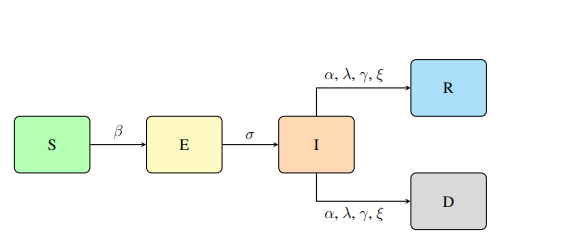

## Sistema de Equações diferenciais

As equações que relacionam as quantidades de pessoas em cada categoria no tempo foram retiradas da [Monografia](https://www.ime.unicamp.br/~mac/db/2020-1S-167296.pdf ) (página 10) e estão no sistema abaixo: 


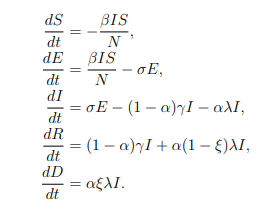

### $\frac{dS}{dt} = -\frac{βIS}{N}$

O número de pessoas suscetíveis diminui (por isso o sinal "$-$") com o contato entre infectados e suscetíveis (indicado pelo produto $IS$) .
A constante $β$ (taxa de infecção) está relacionada com a tendência do contato com infectado infectar um suscetível.


### $\frac{dE}{dt} = \frac{βIS}{N} - σE$

Note que $\frac{βIS}{N}$ é a variação (negativa) de $S$ no tempo, isto é, o número de pessoas expostas aumenta com a diminuição de pessoas suscetíveis.
$σE$ indica que o número de expostos diminui a medida que o período de incubação (relacionado a constante σ) termina e o indivíduo exposto adoece (torna-se infectado).


### $\frac{dI}{dt} = σE -(1-α)γI - αλI$
O número de pessoas infectadas aumenta com o final do período de incubação ($σE$) dos expostos, e diminui com a melhora (ou morte) dos infectados:       
 
1.   Os que não precisaram ir ao hospital ( $(1-α)I$ ) melhoram a uma taxa $γ$.
2.   Os que precisaram ir ao hospital ($αI$) melhoram (ou morrem) a uma taxa $λ$, que está relacionada ao tempo de internação.

estão infectados $αλI$  

### $\frac{dR}{dt} = (1-α)γI + α(1-ξ)λI$
O número de recuperados aumenta com a melhora tanto dos infectados que não se internaram ($(1-α)γI$) , como a dos que se internaram ($α(1-ξ)λI$).
$ξ$ é a letalidade, portanto $(1-ξ)$ ésta relaciondo com os internados que não morreram.

### $\frac{dD}{dt} = αξλI$
O número de mortos aumenta com a tendência dos infectados ($I$) a piorarem e precisarem de internação ($α$), não resistirem a doença ($ξ$) e sairem do hospital a uma taxa ($λ$).

## Código

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [50]:
class SEIRD:
    
    # valores default são relacionados
    # aos dados obtidos nas fontes descritas ao final 
    def __init__(self, 
                 periodo_incubacao    = 5.5,
                 taxa_infeccao        = 0.69,
                 taxa_internacao      = 0.2,
                 Tempo_internado      = 22,
                 Tempo_doente         = 20,
                 mortalidade          = 0.03,
                 y0 = (9674793 - 1, 0,1,0,0)):     # y0 = (S0,E0,I0,R0,D0)

        self.β  =  taxa_infeccao            # o quanto tende uma pessoa exposta a ficar doente
        self.σ  = 1/periodo_incubacao       # taxa de incubacao (tempo médio)
        self.γ  = 1/Tempo_doente            # 1/(tempo doente que não foi ao internado)
        self.λ  =  1/Tempo_internado        # 1/(tempo  doente que ficou internado)
        self.α  = taxa_internacao           # o quanto um infectado tende a internar-se
        self.ξ  = mortalidade               # taxa mortalidade do hospital 
        self.y0 = y0                        # condições iniciais
        self.y = None                       # solução do sistema de equações: y = (S,E,I,R,D) 


    def solve(self):

        def equacao(y, t, N, beta, sigma, alpha, gamma, Lambda, csi):
            S,E,I,R,D     =  y
            β, σ, α, γ, λ, ξ =  beta, sigma, alpha, gamma, Lambda, csi
            
            dSdt = -β*I*S/N                 # Suscetiveis diminui com o numero de infectados
            dEdt = β*I*S/N - σ*E            # Expostos aumentam se temos muitos infectados e diminui quando ficam infectados
            dIdt = σ*E - (1-α)*γ*I - α*λ*I  # Infectados aumentam com mais exposição e diminuem com recuperacao
            dRdt = (1-α)*γ*I + α*(1-ξ)*λ*I  # Recuperados aumentam com recuperacoes em casa e alta do hospital
            dDdt = α*ξ*λ*I                  # Mortos aumentam com infectados que foram internados morreram no hospital

            return np.array( [dSdt, dEdt, dIdt, dRdt, dDdt] )
        
        def to_int(V):
            return np.array(list(int(v) for v in V))

        #guardamos a solucao
        S,E,I,R,D = odeint( equacao,
                            self.y0,
                            np.linspace(start = 0, stop = 365*3, num = 365*3),
                            args = (
                                    9674793, #numero de habitantes
                                    self.β,
                                    self.σ,
                                    self.α,
                                    self.γ,
                                    self.λ,
                                    self.ξ
                                    )
                    ).T #transposing

        #casting to int   
        self.y = np.array([to_int(S), to_int(E), to_int(I), to_int(R), to_int(D)])
    

    def plot(self):
        #se ainda nao solucionamos,
        #usamos a funcao solve
        if self.y is None: self.solve()

        color = ['g','y','r','c','black']
        #plot em S,E,I,R,D
        for i,Var in enumerate(self.y):
            plt.plot(np.linspace(start = 0, stop = 365*3, num = 365*3),Var, color[i])
        
        plt.legend("SEIRD")
        plt.xlabel("dia") 
        plt.ylabel("populacao")   
    
    def plotInfectadosMortos(self):
        plt.plot(np.linspace(start = 0, stop = 365*3, num = 365*3),self.y[2], 'r')
        plt.plot(np.linspace(start = 0, stop = 365*3, num = 365*3),self.y[-1],'black')

        plt.legend("ID")
        plt.xlabel("dia")   
        plt.ylabel("populacao")

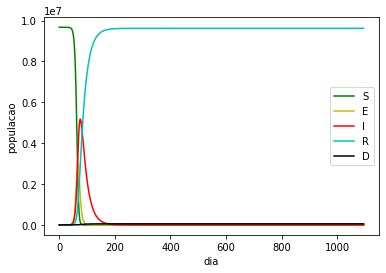

In [68]:
#modelo usando dados das fontes
modelo = SEIRD() 
modelo.plot()

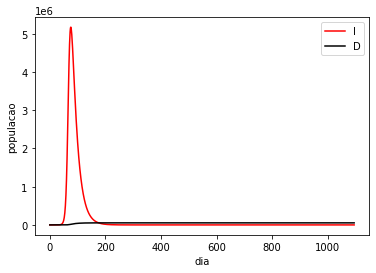

In [69]:
modelo.plotInfectadosMortos()

In [70]:
columns =  np.array(['S','E','I','R','D'])
rows    =  np.arange(0,365*3)
df = pd.DataFrame(data= modelo.y.T,index = rows, columns =columns) #criando DAtaFrame dos valores previstos
df

,S,E,I,R,D
0,9674792,0,1,0,0
1,9674791,0,1,0,0
2,9674790,1,1,0,0
3,9674789,1,1,0,0
4,9674788,2,1,0,0
...,...,...,...,...,...
1090,7,0,0,9621036,53748
1091,7,0,0,9621036,53748
1092,7,0,0,9621036,53748
1093,7,0,0,9621036,53748


Como vemos abaixo, o modelo com tais parâmetros não simula bem a realidade, pois em 398 dias (um ano e um mês aproximadamente) não haveriam mais infectados, com o fim da crise.
Além disso, o número de mortos está bem mais elevado do que o atual.

In [71]:
df.iloc[390:400]

,S,E,I,R,D
390,7,0,1,9621035,53748
391,7,0,1,9621035,53748
392,7,0,1,9621035,53748
393,7,0,1,9621035,53748
394,7,0,1,9621035,53748
395,7,0,1,9621035,53748
396,7,0,1,9621035,53748
397,7,0,1,9621035,53748
398,7,0,0,9621035,53748
399,7,0,0,9621035,53748


A monografia apresenta outros parâmetros, porém também não se adequão bem aos dados de Pernambuco.

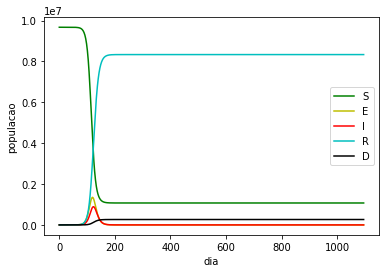

In [61]:
 modeloMonografia = SEIRD()

modeloMonografia.σ = 0.192
modeloMonografia.α = 0.2
modeloMonografia.ξ = 0.3
modeloMonografia.λ = 0.143
modeloMonografia.γ = 0.313

modeloMonografia.plot()

In [63]:
columns =  np.array(['S','E','I','R','D'])
rows    =  np.arange(0,365*3)
df = pd.DataFrame(data= modeloMonografia.y.T,index = rows, columns =columns) #criando DataFrame dos valores previstos
df.iloc[390: 400]

,S,E,I,R,D
390,1073343,0,0,8336931,264517
391,1073343,0,0,8336931,264517
392,1073343,0,0,8336931,264517
393,1073343,0,0,8336931,264517
394,1073343,0,0,8336931,264517
395,1073343,0,0,8336931,264517
396,1073343,0,0,8336931,264517
397,1073343,0,0,8336931,264517
398,1073343,0,0,8336931,264517
399,1073343,0,0,8336931,264517


Podemos  tentar melhorar s previsões modificando o parâmetro β e a letalidade:  

In [82]:
modelo.β = 0.1
modelo.ξ = 0.02
modelo.solve()
columns =  np.array(['S','E','I','R','D'])
rows    =  np.arange(0,365*3)
df = pd.DataFrame(data= modelo.y.T,index = rows, columns =columns) #criando DataFrame dos valores previstos
df.iloc[390: 400]

,S,E,I,R,D
390,8312092,189115,452560,718353,2670
391,8272742,193639,464849,740807,2753
392,8232522,198205,477356,763869,2839
393,8191428,202810,490078,787548,2927
394,8149457,207450,503011,811855,3018
395,8106609,212122,516150,836800,3110
396,8062880,216820,529492,862393,3205
397,8018273,221540,543030,888644,3303
398,7972788,226277,556759,915563,3403
399,7926428,231027,570672,943158,3506


Vemos aqui que o número de mortos ficou mais realista e o número de recuperados é bastante alto. Porém a análise apartir de determinado tempo começa a ficar prejudicada, pois, como dito na introdução, os parâmetros podem variar com as mutações do vírus (que vão ocorrendo mais com o tempo). Além disso, tivemos as medidas preventivas dos lockdowns e, por fim, o número de casos pode ser subnotificado uma vez que muitos não desenvolvem fases mais avançadas da doença e não sentem necessidade de notificar seu caso.

In [81]:
df.iloc[365*2]

S    1872889
E        345
I       2775
R    7784340
D      14442
Name: 730, dtype: int64

### Outros modelos para análise hipotética de vírus com características diferentes

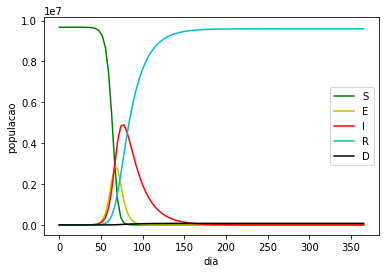

In [6]:
modelo2 = SEIRD(Tempo_internado = 14)
modelo2.plot()

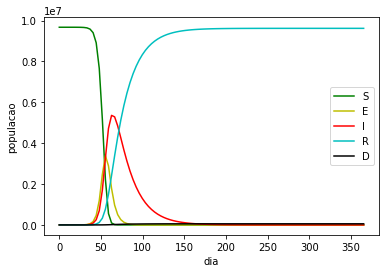

In [7]:
modeloContagioso = SEIRD(taxa_infeccao= 0.9)
modeloContagioso.plot()

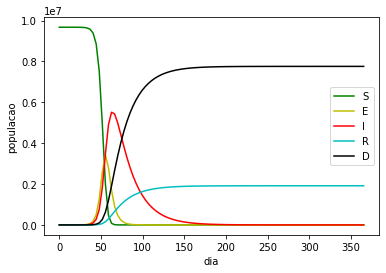

In [9]:
modeloPerigoso = SEIRD(taxa_infeccao=0.9,mortalidade=0.9,taxa_internacao=0.9)
modeloPerigoso.plot()

## Fontes

https://portalarquivos.saude.gov.br/images/af_gvs_coronavirus_6ago20_ajustes-finais-2.pdf

Página 8

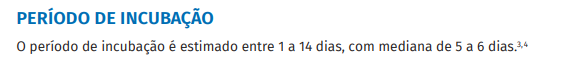

https://www.ibge.gov.br/cidades-e-estados/pe.html


9.674.793 pessoas
 



https://www.cnnbrasil.com.br/saude/internacoes-por-covid-19-duram-em-media-22-dias-aponta-pesquisa/

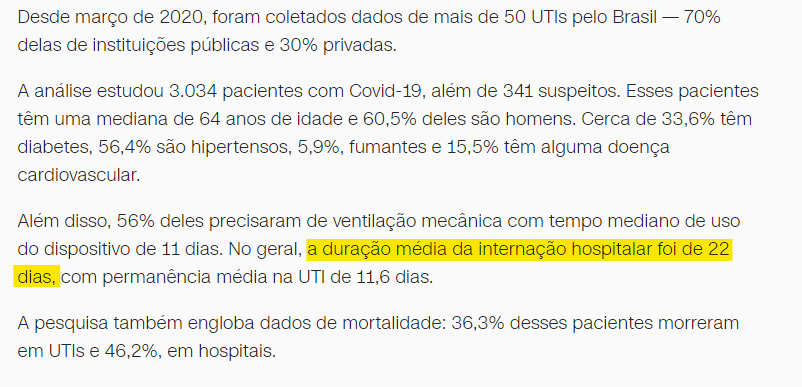

https://dados.seplag.pe.gov.br/apps/corona.html#regula%C3%A7%C3%A3o-srag

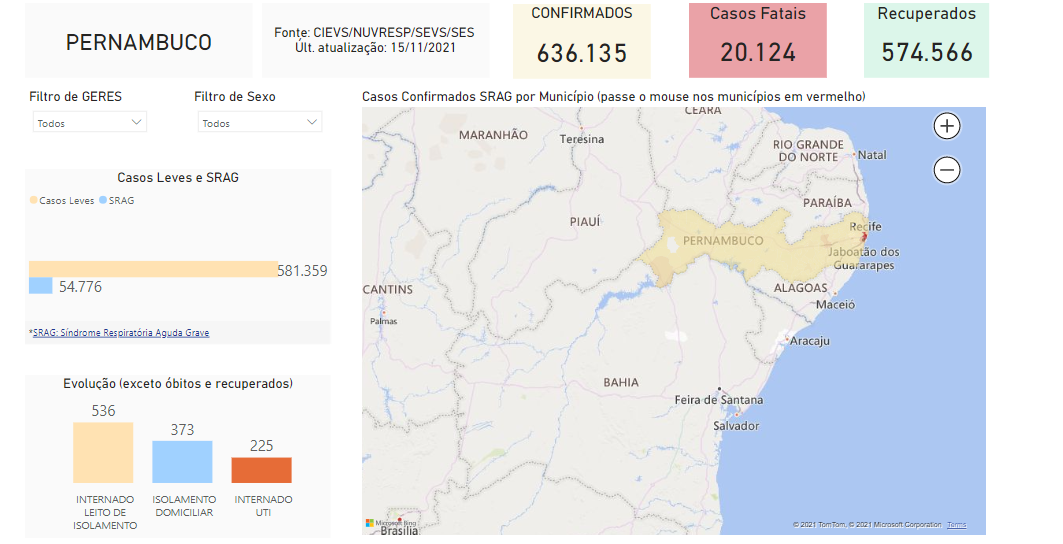

casos confirmados: 636.135

casos fatais: 20.124

mortalidade:  fatais/confirmados = 0,03

https://covid.saude.gov.br/

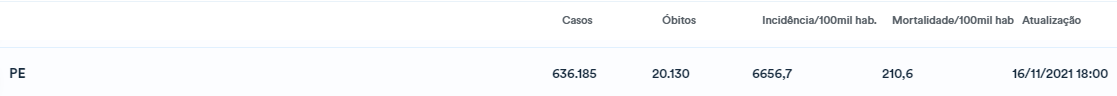